[0: NumPy and the ndarray](gridded_data_tutorial_0.ipynb) | **1: Introduction to xarray** | [2: Daymet data access](gridded_data_tutorial_2.ipynb) | [3: Investigating SWE at Mt. Rainier with Daymet](gridded_data_tutorial_3.ipynb)

# Notebook 1: Introduction to xarray
Waterhackweek 2020 | Steven Pestana (spestana@uw.edu)

**By the end of this notebook you will be able to:**
* Create xarray DataArrays and Datasets
* Index and slice DataArrays and Datasets
* Make plots using xarray objects
* Export xarray Datasets as NetCDF or CSV files

---

#### What do we mean by "gridded data"?

Broadly speaking, this can mean any data with a corresponding location in one or more dimensions. Typically, our dimensions represent points on the Earth's surface in two or three dimensions (latitude,  longitude, and elevation), and often include time as an additional dimension. You may also hear the term "raster" data, which also means data points on some grid. These multi-dimensional datasets can be thought of as 2-D images, stacks of 2-D images, or data "cubes" in 3 or more dimensions. 

Examples of gridded data:
 * Satellite images of Earth's surface, where each pixel represents reflection or emission at some wavelength
 * Climate model output, where the model is evaluated at discrete nodes or grid cells
 
Examples of raster/gridded data formats that combine multi-dimensional data along with metadata in a single file:
* [NetCDF](https://www.unidata.ucar.edu/software/netcdf/docs/) (Network Common Data Form) for model data, satellite imagery, and more
* [GeoTIFF](https://trac.osgeo.org/geotiff/) for georeferenced raster imagery (satellite images, digital elevation models, maps, and more)
* [HDF-EOS](https://earthdata.nasa.gov/esdis/eso/standards-and-references/hdf-eos5) (Hierarchical Data Format - Earth Observing Systems) 
* [GRIB](https://en.wikipedia.org/wiki/GRIB) (GRIdded Binary) for meteorological data

**How can we easily work with these types of data in python?**

Some python packages for working with gridded data:
* [rasterio](https://rasterio.readthedocs.io/en/latest/)
* [xarray](https://xarray.pydata.org/en/stable/)
* [rioxarray](https://corteva.github.io/rioxarray/stable/)
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/)
 
**Today we'll be using xarray!**

---

# xarray

The [xarray](https://xarray.pydata.org/) library allows us to read, manipulate, and create **labeled** multi-dimensional arrays and datasets, such as [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) files.

In the image below, we can imagine having two "data cubes" (3-dimensional data arrays) of temperature and precipitation values, each of which corresponds to a particular x and y spatial coordinate, and t time step.

<img src="https://xarray.pydata.org/en/stable/_images/dataset-diagram.png" width=700>

Let's import xarray and start to explore its features...

In [220]:
# import the package, and give it the alias "xr"
import xarray as xr

# we will also be using numpy and pandas, import both of these
import numpy as np
import pandas as pd

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

---
# DataArrays
Similar to the `numpy.ndarray` object, the `xarray.DataArray` is a multi-dimensional array, with the addition of labeled dimensions, coordinates, and other metadata. A [DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) contains the following: 
* `values` which store the actual data values in a `numpy.ndarray`
* `dims` are the names for each dimension of the `values` array
* `coords` are arrays of labels for each point
* `attrs` is a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) that can contain additional metadata


**Let's create some fake air temperature data to see how these different parts work together to form a DataArray.**

Our goal here is to have 100 years of annual maximum air temperature data for a 10 by 10 grid in a DataArray. (Our data will have a shape of 100 x 10 x 10)

I'm going to use a numpy function to generate some random numbers that are [normally distributed](https://numpy.org/devdocs/reference/random/generated/numpy.random.normal.html) (`np.random.normal()`).

In [129]:
# randomly generated annual maximum air temperature data for a 10 by 10 grid

# choose a mean and standard deviation for our random data
mean = 20
standard_deviation = 5

# specify that we want to generate 100 x 10 x 10 random samples
samples = (100, 10, 10)

# generate the random samples
air_temperature_max = np.random.normal(mean, standard_deviation, samples)

In [130]:
# look at this ndarray we just made
air_temperature_max

array([[[21.58542034, 16.79815134, 21.72300765, ..., 14.50645282,
         20.40285478, 13.47274381],
        [27.30411287, 13.39045374, 16.72225866, ..., 16.56331025,
         17.41801303, 23.04894808],
        [13.34848817, 24.34076711, 24.06814594, ..., 12.20990829,
         22.36164157, 25.41306207],
        ...,
        [18.19092649, 19.56107683, 22.22276348, ..., 13.62815312,
         16.56242817, 14.43718237],
        [18.78658476, 22.98599316, 13.11726929, ..., 16.92748927,
         24.91053473, 26.72876805],
        [14.64560075, 17.25195956, 25.09790073, ..., 26.67290011,
         25.30649138, 21.26351384]],

       [[14.79226318, 15.07381403, 19.84543844, ..., 10.84145446,
         23.36033468, 24.55293149],
        [17.10594175, 27.41363522, 13.09171812, ..., 11.82685666,
         11.19218599, 19.08750711],
        [17.0265471 , 27.38671301, 24.00490622, ..., 31.34573133,
         19.80196776, 25.03335921],
        ...,
        [22.91342422, 15.86718596, 17.32839966, ..., 1

In [132]:
# look at the shape of this ndarray
air_temperature_max.shape

(100, 10, 10)

`air_temperature` will be the `values` within the DataArray. It is a three-dimensional array, and we've given it a shape of 100x10x10. 

The three dimensions will need names (`dims`) and labels (`coords`)

**Make the `coords` that will be our 100 years**

In [133]:
# Make a sequence of 100 years to be our time dimension
years = pd.date_range('1920', periods=100, freq ='1Y')

**Make the `coords` that will be our longitudes and latitudes**

In [134]:
# Make a sequence of linearly spaced longitude and latitude values
lon = np.linspace(-119, -110, 10)
lat = np.linspace(30, 39, 10)

**Make the `dims` names**

In [135]:
# We can call our dimensions time, lat, and lon corresponding to the dimensions with lengths 100 (years) and 10 (lat and lon) respectively
dimensions = ['time', 'lat', 'lon']

**Finally we can create a metadata dictionary which will be included in the DataArray**

In [144]:
metadata = {'units': 'C',
           'description': 'maximum annual air temperature'}

**Now that we have all the individual components of an xarray DataArray, we can create it**

In [145]:
tair_max = xr.DataArray(air_temperature_max, 
                          coords=[years, lat, lon], 
                          dims=dimensions,  
                          name='tair_max', 
                          attrs=metadata)

**Inspect the DataArray we just created**

In [146]:
tair_max

<xarray.DataArray 'tair_max' (time: 100, lat: 10, lon: 10)>
array([[[21.58542034, 16.79815134, 21.72300765, ..., 14.50645282,
         20.40285478, 13.47274381],
        [27.30411287, 13.39045374, 16.72225866, ..., 16.56331025,
         17.41801303, 23.04894808],
        [13.34848817, 24.34076711, 24.06814594, ..., 12.20990829,
         22.36164157, 25.41306207],
        ...,
        [18.19092649, 19.56107683, 22.22276348, ..., 13.62815312,
         16.56242817, 14.43718237],
        [18.78658476, 22.98599316, 13.11726929, ..., 16.92748927,
         24.91053473, 26.72876805],
        [14.64560075, 17.25195956, 25.09790073, ..., 26.67290011,
         25.30649138, 21.26351384]],

       [[14.79226318, 15.07381403, 19.84543844, ..., 10.84145446,
         23.36033468, 24.55293149],
        [17.10594175, 27.41363522, 13.09171812, ..., 11.82685666,
         11.19218599, 19.08750711],
        [17.0265471 , 27.38671301, 24.00490622, ..., 31.34573133,
         19.80196776, 25.03335921],
...
        [22.42153759, 20.77087178, 19.0997142 , ..., 27.58264087,
         18.21910705, 17.2082126 ],
        [15.59931181, 19.7044889 , 10.09782173, ..., 25.31460086,
         11.26430743, 21.40000527],
        [13.33828249, 20.38173731, 17.95601479, ..., 18.16265706,
         14.13316104, 13.92213747]],

       [[21.78718648, 23.41163157, 32.31523954, ..., 18.9508931 ,
         17.06622307, 26.95714817],
        [14.40637181, 17.46811973, 14.40555364, ..., 33.35794803,
         14.2215838 , 24.72037048],
        [18.75381193, 17.61234328, 21.73507383, ..., 20.55292238,
         20.51276793, 18.30028468],
        ...,
        [20.96074411, 19.44124933, 22.94030242, ..., 15.03020251,
         21.67180882, 27.85818706],
        [15.99081214, 24.72971575, 26.88014231, ..., 27.21959087,
         24.95286316, 15.92915369],
        [21.92375025, 21.48232404, 27.24533425, ..., 11.5612212 ,
         19.41152785, 25.81126141]]])
Coordinates:
  * time     (time) datetime64[ns] 1920-12-31 1921-12-31 ... 2019-12-31
  * lat      (lat) float64 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0
  * lon      (lon) float64 -119.0 -118.0 -117.0 -116.0 ... -112.0 -111.0 -110.0
Attributes:
    units:        C
    description:  maximum annual air temperature

In [147]:
# Get the DataArray dimensions (labels for coordinates)
tair_max.dims

('time', 'lat', 'lon')

In [148]:
# Get the DataArray coordinates
tair_max.coords

Coordinates:
  * time     (time) datetime64[ns] 1920-12-31 1921-12-31 ... 2019-12-31
  * lat      (lat) float64 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0
  * lon      (lon) float64 -119.0 -118.0 -117.0 -116.0 ... -112.0 -111.0 -110.0

In [149]:
# Look at our attributes
tair_max.attrs

{'units': 'C', 'description': 'maximum annual air temperature'}

In [150]:
# Take a look at the data values
tair_max.values

array([[[21.58542034, 16.79815134, 21.72300765, ..., 14.50645282,
         20.40285478, 13.47274381],
        [27.30411287, 13.39045374, 16.72225866, ..., 16.56331025,
         17.41801303, 23.04894808],
        [13.34848817, 24.34076711, 24.06814594, ..., 12.20990829,
         22.36164157, 25.41306207],
        ...,
        [18.19092649, 19.56107683, 22.22276348, ..., 13.62815312,
         16.56242817, 14.43718237],
        [18.78658476, 22.98599316, 13.11726929, ..., 16.92748927,
         24.91053473, 26.72876805],
        [14.64560075, 17.25195956, 25.09790073, ..., 26.67290011,
         25.30649138, 21.26351384]],

       [[14.79226318, 15.07381403, 19.84543844, ..., 10.84145446,
         23.36033468, 24.55293149],
        [17.10594175, 27.41363522, 13.09171812, ..., 11.82685666,
         11.19218599, 19.08750711],
        [17.0265471 , 27.38671301, 24.00490622, ..., 31.34573133,
         19.80196776, 25.03335921],
        ...,
        [22.91342422, 15.86718596, 17.32839966, ..., 1

---

## DataArray indexing/slicing methods

DataArrays can be [indexed or sliced](https://xarray.pydata.org/en/stable/indexing.html) much like ndarrays, but  with the addition of using labels.

| Dimension lookup | Index lookup | DataArray syntax |
| ---              | ---          | ---              |
| positional       | by integer   | `da[:,0]`        |
| positional       | by label     | `da.loc[:,'east_watershed']` |
| by name          | by integer   | `da.isel(watershed=0)` |
| by name          | by label     | `da.sel(watershed='east_watershed')` |

Let's select by name and by label, air temperature for just one year, and plot it. (Conveniently, x-array will add axes labels and a title by default.)

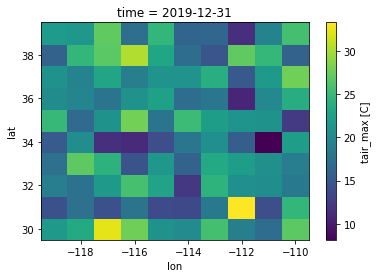

In [151]:
tair_max.sel(time='2019').plot()

Similarly we can select by longitude and latitude to plot a timeseries. (We made this easy on ourselves here by choosing whole number integers for our longitude and latitude)

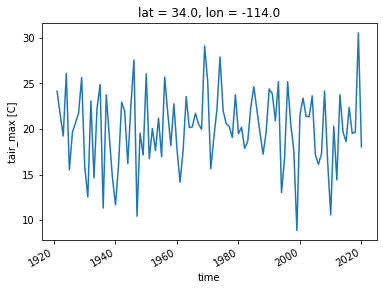

In [152]:
tair_max.sel(lat=34, lon=-114).plot()

Now let's select a shorter time range using a `slice()` to plot data for this location.

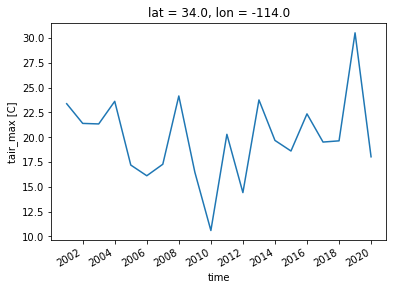

In [153]:
tair_max.sel(lat=34, lon=-114, time=slice('2000','2020')).plot()

And if we try to plot the whole DataArray, xarray gives us a histogram!

(array([   4.,   43.,  361., 1377., 2898., 2967., 1730.,  531.,   84.,
           5.]),
 array([-0.98389873,  3.12054283,  7.22498439, 11.32942596, 15.43386752,
        19.53830908, 23.64275064, 27.7471922 , 31.85163376, 35.95607533,
        40.06051689]),
 <BarContainer object of 10 artists>)

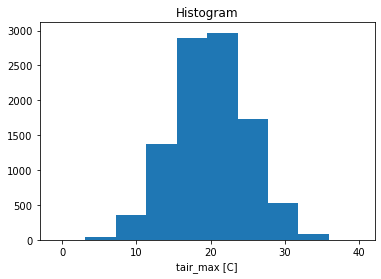

In [154]:
tair_max.plot()

---
# Datasets

Similar to the `pandas.dataframe`, the `xarray.Dataset` contains one or more labeled `xarray.DataArray` objects.

We can create a [Dataset](https://xarray.pydata.org/en/stable/data-structures.html#dataset) with our simulated data here. 

**First, create a two more DataArrays with annual miminum air temperatures, and annual cumulative precipitation**

In [155]:
# randomly generated annual minimum air temperature data for a 10 by 10 grid
air_temperature_min = np.random.normal(-10, 10, (100, 10, 10))

# randomly generated annualcumulative precipitation data for a 10 by 10 grid
cumulative_precip = np.random.normal(100, 25, (100, 10, 10))

Make the DataArrays (note that we're using the same `coords` and `dims` as our first maximum air temperature DataArray)

In [223]:
tair_min = xr.DataArray(air_temperature_min, 
                      coords=[years, lat, lon],  
                      dims=dimensions, 
                      name='tair_min', 
                      attrs={'units':'C', 
                             'description': 'minimum annual air temperature'})

precip = xr.DataArray(cumulative_precip, 
                      coords=[years, lat, lon],  
                      dims=dimensions, 
                      name='cumulative_precip', 
                      attrs={'units':'cm', 
                             'description': 'annual cumulative precipitation'})

**Now merge our two DataArrays and create a Dataset.**

In [224]:
my_data = xr.merge([tair_max, tair_min, precip])

In [225]:
# inspect the Dataset
my_data

<xarray.Dataset>
Dimensions:            (lat: 10, lon: 10, time: 100)
Coordinates:
  * time               (time) datetime64[ns] 1920-12-31 ... 2019-12-31
  * lat                (lat) float64 30.0 31.0 32.0 33.0 ... 36.0 37.0 38.0 39.0
  * lon                (lon) float64 -119.0 -118.0 -117.0 ... -111.0 -110.0
Data variables:
    tair_max           (time, lat, lon) float64 21.59 16.8 21.72 ... 19.41 25.81
    tair_min           (time, lat, lon) float64 -2.189 -16.22 ... -1.148 -12.68
    cumulative_precip  (time, lat, lon) float64 113.4 125.7 ... 125.5 107.3

## Dataset indexing/slicing methods

Datasets can also be [indexed or sliced](https://xarray.pydata.org/en/stable/indexing.html) using the `.isel()` or `.sel()` methods.




| Dimension lookup | Index lookup | Dataset syntax |
| ---              | ---          | ---            |
| positional       | by integer   | *n/a* |
| positional       | by label     | *n/a* |
| by name          | by integer   | `ds.isel(location=0)` |
| by name          | by label     | `ds.sel(location='stream_gage_1')` |

**Select with `.sel()` temperatures and precipitation for just one grid cell**

In [188]:
# by name, by label
my_data.sel(lon='-114', lat='35')

<xarray.Dataset>
Dimensions:            (time: 100)
Coordinates:
  * time               (time) datetime64[ns] 1920-12-31 ... 2019-12-31
    lat                float64 35.0
    lon                float64 -114.0
Data variables:
    tair_max           (time) float64 22.61 20.61 27.63 ... 25.4 11.36 25.34
    tair_min           (time) float64 -11.66 -25.75 -16.61 ... 0.9944 -6.958
    cumulative_precip  (time) float64 121.9 75.09 164.0 ... 22.08 42.14 112.4

**Select with `.isel()` temperatures and precipitation for just one year**

In [189]:
# by name, by integer
my_data.isel(time=0)

<xarray.Dataset>
Dimensions:            (lat: 10, lon: 10)
Coordinates:
    time               datetime64[ns] 1920-12-31
  * lat                (lat) float64 30.0 31.0 32.0 33.0 ... 36.0 37.0 38.0 39.0
  * lon                (lon) float64 -119.0 -118.0 -117.0 ... -111.0 -110.0
Data variables:
    tair_max           (lat, lon) float64 21.59 16.8 21.72 ... 26.67 25.31 21.26
    tair_min           (lat, lon) float64 -2.189 -16.22 -3.951 ... -37.91 -7.974
    cumulative_precip  (lat, lon) float64 113.4 125.7 67.78 ... 108.2 74.8 97.97

---

## Make some plots:

Using our indexing/slicing methods, create some plots showing 1) a timseries of all three variables at a single point, then 2) plot some maps of each variable for two points in time.

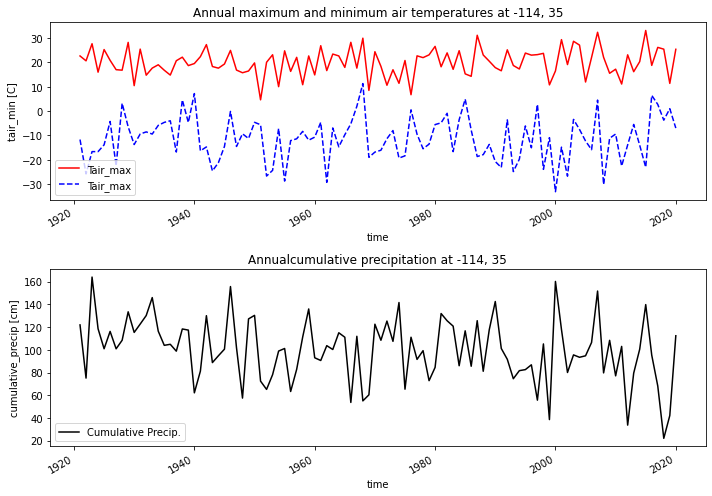

In [219]:
# 1) create a timeseries for the two temperature variables for a single location

# create a figure with 2 rows and 1 column of subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,7), tight_layout=True)

# pick a longitude and latitude in our dataset
my_lon=-114
my_lat=35

# first subplot
# Plot tair_max
my_data.sel(lon=my_lon, lat=my_lat).tair_max.plot(ax=ax[0], color='r', linestyle='-', label='Tair_max')
# Plot tair_min
my_data.sel(lon=my_lon, lat=my_lat).tair_min.plot(ax=ax[0], color='b', linestyle='--', label='Tair_max')
# Add a title
ax[0].set_title('Annual maximum and minimum air temperatures at {}, {}'.format(my_lon,my_lat))
# Add a legend
ax[0].legend(loc='lower left')

# second subplot
# Plot precip
my_data.sel(lon=my_lon, lat=my_lat).cumulative_precip.plot(ax=ax[1], color='black', linestyle='-', label='Cumulative Precip.')
# Add a title
ax[1].set_title('Annualcumulative precipitation at {}, {}'.format(my_lon,my_lat))
# Add a legend
ax[1].legend(loc='lower left')

# Save the figure
plt.savefig('my_data_plot_timeseries.jpg')

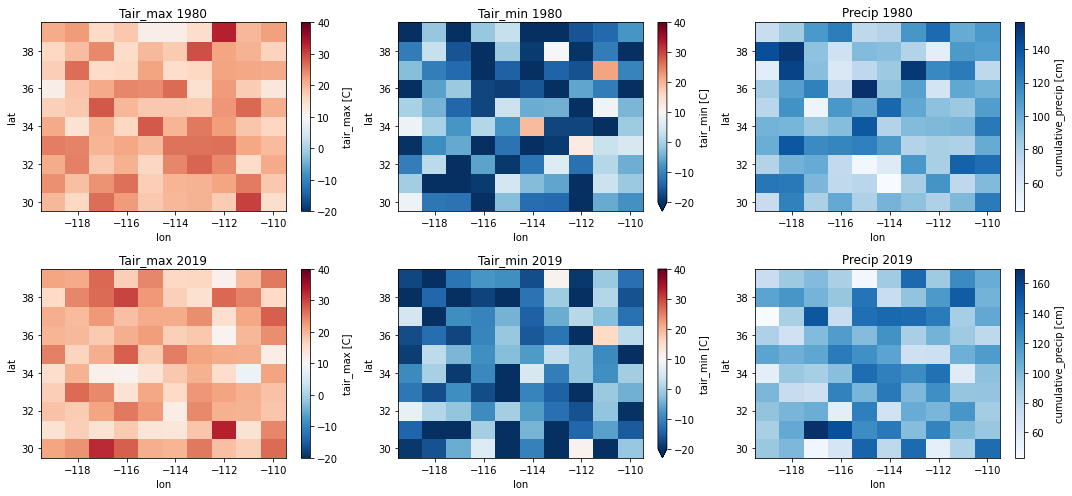

In [196]:
# 2) plot maps of temperature and precipitation for two years

# create a figure with 2 rows and 3 columns of subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,7), tight_layout=True)

# The two years we want to plot
year1 = '1980'
year2 = '2019'

# Plot tair_max for the year 1980
my_data.sel(time=year1).tair_max.plot(ax=ax[0,0], cmap='RdBu_r', vmin=-20, vmax=40)
# set a title for this subplot
ax[0,0].set_title('Tair_max {}'.format(year1));

# Plot tair_max for the year 1980
my_data.sel(time=year1).tair_min.plot(ax=ax[0,1], cmap='RdBu_r', vmin=-20, vmax=40)
# set a title for this subplot
ax[0,1].set_title('Tair_min {}'.format(year1));

# Plot tair_max for the year 1980
my_data.sel(time=year1).cumulative_precip.plot(ax=ax[0,2], cmap='Blues')
# set a title for this subplot
ax[0,2].set_title('Precip {}'.format(year1));


# Plot tair_max for the year 2019
my_data.sel(time=year2).tair_max.plot(ax=ax[1,0], cmap='RdBu_r', vmin=-20, vmax=40)
# set a title for this subplot
ax[1,0].set_title('Tair_max {}'.format(year2));

# Plot tair_max for the year 2019
my_data.sel(time=year2).tair_min.plot(ax=ax[1,1], cmap='RdBu_r', vmin=-20, vmax=40)
# set a title for this subplot
ax[1,1].set_title('Tair_min {}'.format(year2));

# Plot tair_max for the year 2019
my_data.sel(time=year2).cumulative_precip.plot(ax=ax[1,2], cmap='Blues')
# set a title for this subplot
ax[1,2].set_title('Precip {}'.format(year2));


# save the figure as a jpg image
plt.savefig('my_data_plot_rasters.jpg')

---
## Save our data to a file:

**As a NetCDF file:**

In [197]:
my_data.to_netcdf('my_data.nc')

**We can also convert a Dataset or DataArray to a pandas dataframe**

In [198]:
my_data.to_dataframe()

tair_max   tair_min  cumulative_precip
lat  lon    time                                               
30.0 -119.0 1920-12-31  21.585420  -2.188885         113.412453
            1921-12-31  14.792263 -14.404272         115.662995
            1922-12-31  16.560758  -7.794034         134.616368
            1923-12-31  26.188096   3.594553          74.092883
            1924-12-31  16.663546 -13.913690         129.112676
...                           ...        ...                ...
39.0 -110.0 2015-12-31  20.270914 -31.809173         115.161552
            2016-12-31  21.412521 -20.832375          79.012673
            2017-12-31  21.473633 -10.491872         119.597715
            2018-12-31  13.922137 -33.911799         121.943270
            2019-12-31  25.811261 -12.682344         107.275272

[10000 rows x 3 columns]

**Via a pandas dataframe, save our data to a csv file**

In [199]:
my_data.to_dataframe().to_csv('my_data.csv')